In [2]:
#Import
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import randint
from numpy.random import rand
from numpy import zeros
from numpy import ones
from matplotlib import pyplot
import random
from numpy import vstack

Using TensorFlow backend.


In [4]:

#Input dimension generator
input_dim = 100

# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.4))
discriminator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.4))
discriminator.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
discriminator.add(Dropout(0.4))
discriminator.add(Dense(1, activation='sigmoid'))  
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

discriminator.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________

C:\Users\Zimon\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))



Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0

In [5]:
#Generator-model
generator = Sequential()
generator.add(Dense(256, input_dim=input_dim, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
generator.add(Dense(784, activation='tanh'))  
generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               803600    
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


In [6]:
#GAN-model
discriminator.trainable = False
inputs = Input(shape=(input_dim, ))
hidden = generator(inputs)
output = discriminator(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [7]:
#Load and preprocess data from MNIST
(x_train, _), (_, _) = mnist.load_data()


x_train = (x_train - 127.5)/127.5
print(x_train.shape)
x_train = x_train.reshape(60000, 784)
print(x_train.shape)

(60000, 28, 28)
(60000, 784)


In [8]:
# select real samples
def generate_real_samples(x_train, n_samples):
    # choose random instances
    ix = randint(0, x_train.shape[0], n_samples)
    # retrieve selected images
    X = x_train[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
# generate n noise samples with class labels
def generate_noise_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(784 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 784))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(input_dim, n_samples):
    # generate points in the latent space
    x_input = randn(input_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, input_dim)
    return x_input
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    x = model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return x, y



In [16]:
#Train discriminator
def train_discriminator(model, dataset, number_iteration, batch_size):
    half_batch = int(batch_size/2)
    for i in range(number_iteration):
        #Sample from real images
        x_real, y_real = generate_real_samples(x_train,(half_batch))
        #Sample from noise
        x_noise, y_noise = generate_noise_samples((half_batch))
        #Train with real images
        _, real_acc = model.train_on_batch(x_real, y_real)
        print(x_real.shape)
        #Train with noise
        _, noise_acc = model.train_on_batch(x_noise, y_noise)
        print('>%d real=%.0f%% noise=%.0f%%' % (i+1, real_acc*100, noise_acc*100))
        
train_discriminator(discriminator, x_train, 25, 256)

(128, 784)
>1 real=100% noise=100%
(128, 784)
>2 real=100% noise=100%
(128, 784)
>3 real=100% noise=100%
(128, 784)
>4 real=100% noise=100%
(128, 784)
>5 real=100% noise=100%
(128, 784)
>6 real=100% noise=100%
(128, 784)
>7 real=100% noise=100%
(128, 784)
>8 real=100% noise=100%
(128, 784)
>9 real=100% noise=100%
(128, 784)
>10 real=100% noise=100%
(128, 784)
>11 real=100% noise=100%
(128, 784)
>12 real=100% noise=100%
(128, 784)
>13 real=100% noise=100%
(128, 784)
>14 real=100% noise=100%
(128, 784)
>15 real=100% noise=100%
(128, 784)
>16 real=100% noise=100%
(128, 784)
>17 real=100% noise=100%
(128, 784)
>18 real=100% noise=100%
(128, 784)
>19 real=100% noise=100%
(128, 784)
>20 real=100% noise=100%
(128, 784)
>21 real=100% noise=100%
(128, 784)
>22 real=100% noise=100%
(128, 784)
>23 real=100% noise=100%
(128, 784)
>24 real=100% noise=100%
(128, 784)
>25 real=100% noise=100%


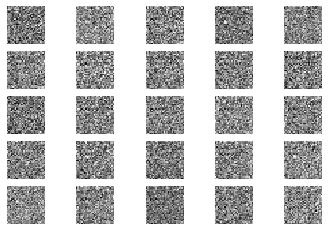

In [11]:
n_samples = 25
x, _ = generate_fake_samples(generator, input_dim, n_samples)
x = x.reshape(n_samples, 28, 28)
for i in range(n_samples):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(x[i], cmap='gray_r')
    
pyplot.show()

In [12]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [13]:
def train_gan(generator, discriminator, gan, x_train, input_dim, n_epochs, batch_size):
    batch_per_epoch = int(x_train.shape[0]/batch_size)
    half_batch = int(batch_size/2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            x_real, y_real = generate_real_samples(x_train, half_batch)
            x_fake, y_fake = generate_fake_samples(generator, input_dim, half_batch)
            x, y = vstack((x_real, x_fake)), vstack((y_real, y_fake))
            discriminator_loss = discriminator.train_on_batch(x, y)
            x_gan = generate_latent_points(input_dim, batch_size)
            y_gan = ones((batch_size, 1))
            generator_loss = gan.train_on_batch(x_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, discriminator_loss[0], generator_loss[0]))
            # evaluate the model performance, sometimes
            if (j==1):
                summarize_performance(i, generator, discriminator, x_train, input_dim)
train_gan(generator,discriminator,gan,x_train,input_dim, 5, 256)

>1, 1/234, d=0.361, g=0.874
>1, 2/234, d=0.741, g=0.471
>Accuracy real: 100%, fake: 0%
>1, 3/234, d=0.965, g=0.497
>1, 4/234, d=0.799, g=0.811
>1, 5/234, d=0.689, g=0.899
>1, 6/234, d=0.665, g=0.813
>1, 7/234, d=0.645, g=0.866
>1, 8/234, d=0.700, g=1.015
>1, 9/234, d=0.650, g=1.022
>1, 10/234, d=0.696, g=0.995
>1, 11/234, d=0.707, g=0.976
>1, 12/234, d=0.671, g=1.059
>1, 13/234, d=0.670, g=1.124
>1, 14/234, d=0.604, g=1.023
>1, 15/234, d=0.603, g=1.041
>1, 16/234, d=0.622, g=1.053
>1, 17/234, d=0.654, g=0.940
>1, 18/234, d=0.651, g=0.912
>1, 19/234, d=0.658, g=0.885
>1, 20/234, d=0.648, g=0.935
>1, 21/234, d=0.649, g=0.898
>1, 22/234, d=0.649, g=0.906
>1, 23/234, d=0.633, g=0.956
>1, 24/234, d=0.613, g=0.967
>1, 25/234, d=0.650, g=0.878
>1, 26/234, d=0.650, g=0.842
>1, 27/234, d=0.631, g=0.882
>1, 28/234, d=0.704, g=0.841
>1, 29/234, d=0.705, g=0.773
>1, 30/234, d=0.670, g=0.890
>1, 31/234, d=0.702, g=0.802
>1, 32/234, d=0.652, g=0.863
>1, 33/234, d=0.629, g=0.884
>1, 34/234, d=0.614, 

>2, 44/234, d=0.651, g=0.988
>2, 45/234, d=0.681, g=2.270
>2, 46/234, d=0.683, g=0.907
>2, 47/234, d=0.686, g=1.426
>2, 48/234, d=0.498, g=1.711
>2, 49/234, d=0.538, g=1.245
>2, 50/234, d=0.515, g=1.497
>2, 51/234, d=0.477, g=1.661
>2, 52/234, d=0.522, g=1.009
>2, 53/234, d=0.586, g=1.611
>2, 54/234, d=0.564, g=1.390
>2, 55/234, d=0.562, g=0.974
>2, 56/234, d=0.567, g=1.774
>2, 57/234, d=0.514, g=1.316
>2, 58/234, d=0.479, g=1.359
>2, 59/234, d=0.526, g=1.422
>2, 60/234, d=0.583, g=1.200
>2, 61/234, d=0.552, g=1.910
>2, 62/234, d=0.592, g=0.864
>2, 63/234, d=0.577, g=1.635
>2, 64/234, d=0.485, g=1.720
>2, 65/234, d=0.503, g=0.976
>2, 66/234, d=0.544, g=1.733
>2, 67/234, d=0.550, g=1.162
>2, 68/234, d=0.509, g=1.212
>2, 69/234, d=0.485, g=1.319
>2, 70/234, d=0.525, g=1.117
>2, 71/234, d=0.479, g=1.555
>2, 72/234, d=0.497, g=1.149
>2, 73/234, d=0.489, g=1.551
>2, 74/234, d=0.439, g=1.328
>2, 75/234, d=0.488, g=1.399
>2, 76/234, d=0.495, g=1.729
>2, 77/234, d=0.493, g=1.023
>2, 78/234, d=

>3, 88/234, d=0.504, g=1.891
>3, 89/234, d=0.632, g=0.869
>3, 90/234, d=0.673, g=2.068
>3, 91/234, d=0.644, g=1.067
>3, 92/234, d=0.562, g=1.011
>3, 93/234, d=0.518, g=1.329
>3, 94/234, d=0.545, g=1.267
>3, 95/234, d=0.510, g=1.156
>3, 96/234, d=0.543, g=1.523
>3, 97/234, d=0.538, g=1.273
>3, 98/234, d=0.564, g=1.279
>3, 99/234, d=0.517, g=1.302
>3, 100/234, d=0.499, g=1.376
>3, 101/234, d=0.512, g=1.476
>3, 102/234, d=0.540, g=1.302
>3, 103/234, d=0.514, g=1.500
>3, 104/234, d=0.492, g=1.465
>3, 105/234, d=0.501, g=1.221
>3, 106/234, d=0.528, g=1.639
>3, 107/234, d=0.502, g=0.866
>3, 108/234, d=0.537, g=1.986
>3, 109/234, d=0.564, g=0.988
>3, 110/234, d=0.543, g=1.751
>3, 111/234, d=0.507, g=1.410
>3, 112/234, d=0.517, g=1.320
>3, 113/234, d=0.459, g=1.660
>3, 114/234, d=0.433, g=1.429
>3, 115/234, d=0.465, g=1.297
>3, 116/234, d=0.478, g=1.838
>3, 117/234, d=0.479, g=1.269
>3, 118/234, d=0.453, g=1.688
>3, 119/234, d=0.496, g=1.257
>3, 120/234, d=0.541, g=1.808
>3, 121/234, d=0.496, 

>4, 131/234, d=0.497, g=2.540
>4, 132/234, d=0.535, g=0.748
>4, 133/234, d=0.640, g=2.127
>4, 134/234, d=0.499, g=1.429
>4, 135/234, d=0.525, g=1.327
>4, 136/234, d=0.484, g=1.953
>4, 137/234, d=0.510, g=1.265
>4, 138/234, d=0.464, g=1.861
>4, 139/234, d=0.515, g=1.563
>4, 140/234, d=0.481, g=1.396
>4, 141/234, d=0.509, g=1.884
>4, 142/234, d=0.600, g=0.777
>4, 143/234, d=0.592, g=2.141
>4, 144/234, d=0.490, g=1.368
>4, 145/234, d=0.418, g=1.240
>4, 146/234, d=0.457, g=1.825
>4, 147/234, d=0.472, g=1.727
>4, 148/234, d=0.394, g=1.419
>4, 149/234, d=0.448, g=1.861
>4, 150/234, d=0.476, g=1.216
>4, 151/234, d=0.486, g=1.970
>4, 152/234, d=0.475, g=1.430
>4, 153/234, d=0.506, g=1.170
>4, 154/234, d=0.462, g=2.129
>4, 155/234, d=0.514, g=1.187
>4, 156/234, d=0.550, g=1.692
>4, 157/234, d=0.394, g=1.688
>4, 158/234, d=0.386, g=1.401
>4, 159/234, d=0.427, g=1.695
>4, 160/234, d=0.361, g=1.671
>4, 161/234, d=0.446, g=1.493
>4, 162/234, d=0.456, g=1.909
>4, 163/234, d=0.444, g=1.415
>4, 164/23

>5, 174/234, d=0.499, g=3.305
>5, 175/234, d=0.592, g=0.768
>5, 176/234, d=0.616, g=2.699
>5, 177/234, d=0.599, g=1.514
>5, 178/234, d=0.444, g=1.256
>5, 179/234, d=0.407, g=2.079
>5, 180/234, d=0.482, g=1.505
>5, 181/234, d=0.404, g=1.355
>5, 182/234, d=0.442, g=1.868
>5, 183/234, d=0.405, g=1.525
>5, 184/234, d=0.458, g=1.833
>5, 185/234, d=0.524, g=1.836
>5, 186/234, d=0.496, g=2.086
>5, 187/234, d=0.445, g=1.483
>5, 188/234, d=0.487, g=2.443
>5, 189/234, d=0.497, g=0.953
>5, 190/234, d=0.589, g=2.429
>5, 191/234, d=0.583, g=1.410
>5, 192/234, d=0.471, g=1.452
>5, 193/234, d=0.443, g=1.995
>5, 194/234, d=0.445, g=1.586
>5, 195/234, d=0.431, g=1.663
>5, 196/234, d=0.475, g=1.702
>5, 197/234, d=0.450, g=1.689
>5, 198/234, d=0.469, g=1.968
>5, 199/234, d=0.461, g=1.926
>5, 200/234, d=0.476, g=1.374
>5, 201/234, d=0.466, g=1.998
>5, 202/234, d=0.506, g=1.762
>5, 203/234, d=0.411, g=1.515
>5, 204/234, d=0.449, g=2.042
>5, 205/234, d=0.422, g=1.820
>5, 206/234, d=0.426, g=1.481
>5, 207/23

In [3]:
n_samples = 25
pyplot.figure(figsize=(10, 10))
x, _ = generate_fake_samples(generator, input_dim, n_samples)
x = x.reshape(n_samples, 28, 28)
for i in range(n_samples):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(x[i], cmap='gray_r')
    
    
pyplot.show()

NameError: name 'generate_fake_samples' is not defined

<Figure size 720x720 with 0 Axes>

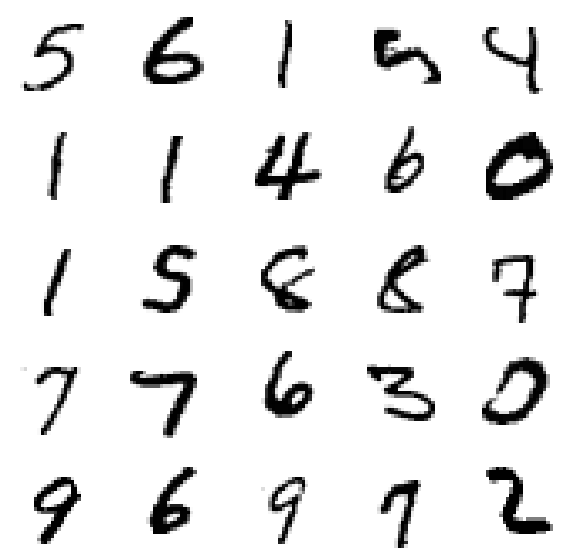

In [22]:
n_samples = 25
pyplot.figure(figsize=(10, 10))
x, _ = generate_real_samples(x_train, n_samples)
x = x.reshape(n_samples, 28, 28)
for i in range(n_samples):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(x[i], cmap='gray_r')
    
pyplot.show()